Sentiment Backtesting Results Analysis

Generating mock data...
Mock data generated successfully!

BACKTEST SUMMARY STATISTICS

                    Execution Timing Long/Short Alpha
Sharpe Ratio                  -23.10             0.38
Total P&L (bps)               -25177             1350
Avg Daily P&L (bps)           -96.09             5.15
Max Drawdown (bps)            -25062            -4870
Win Rate                        7.3%            50.0%

Generating visualizations...

1. Cumulative P&L...


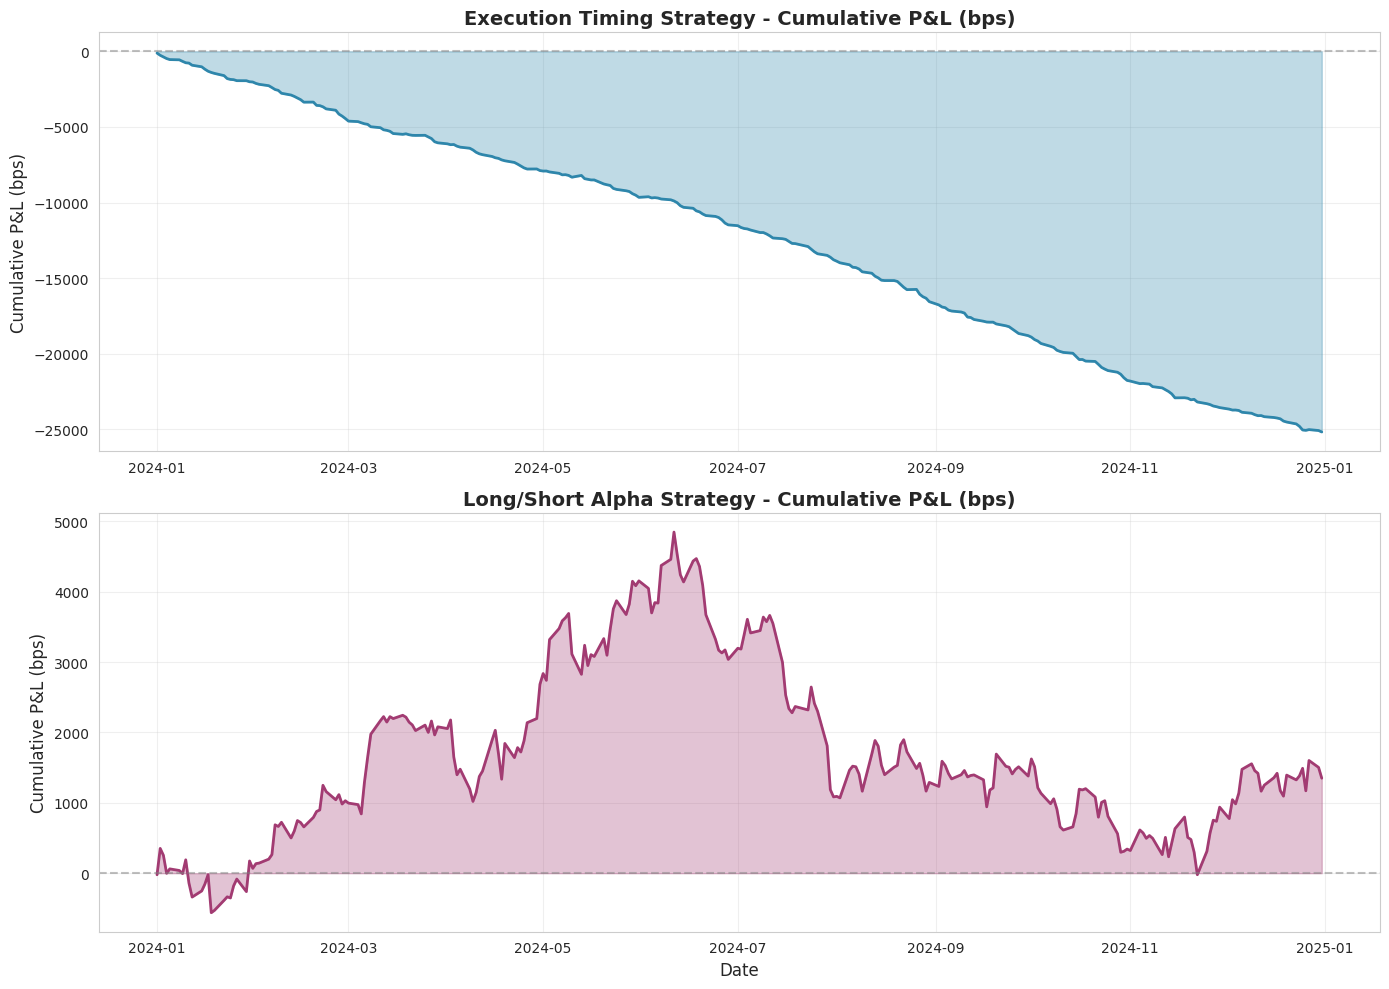

2. Drawdown Analysis...


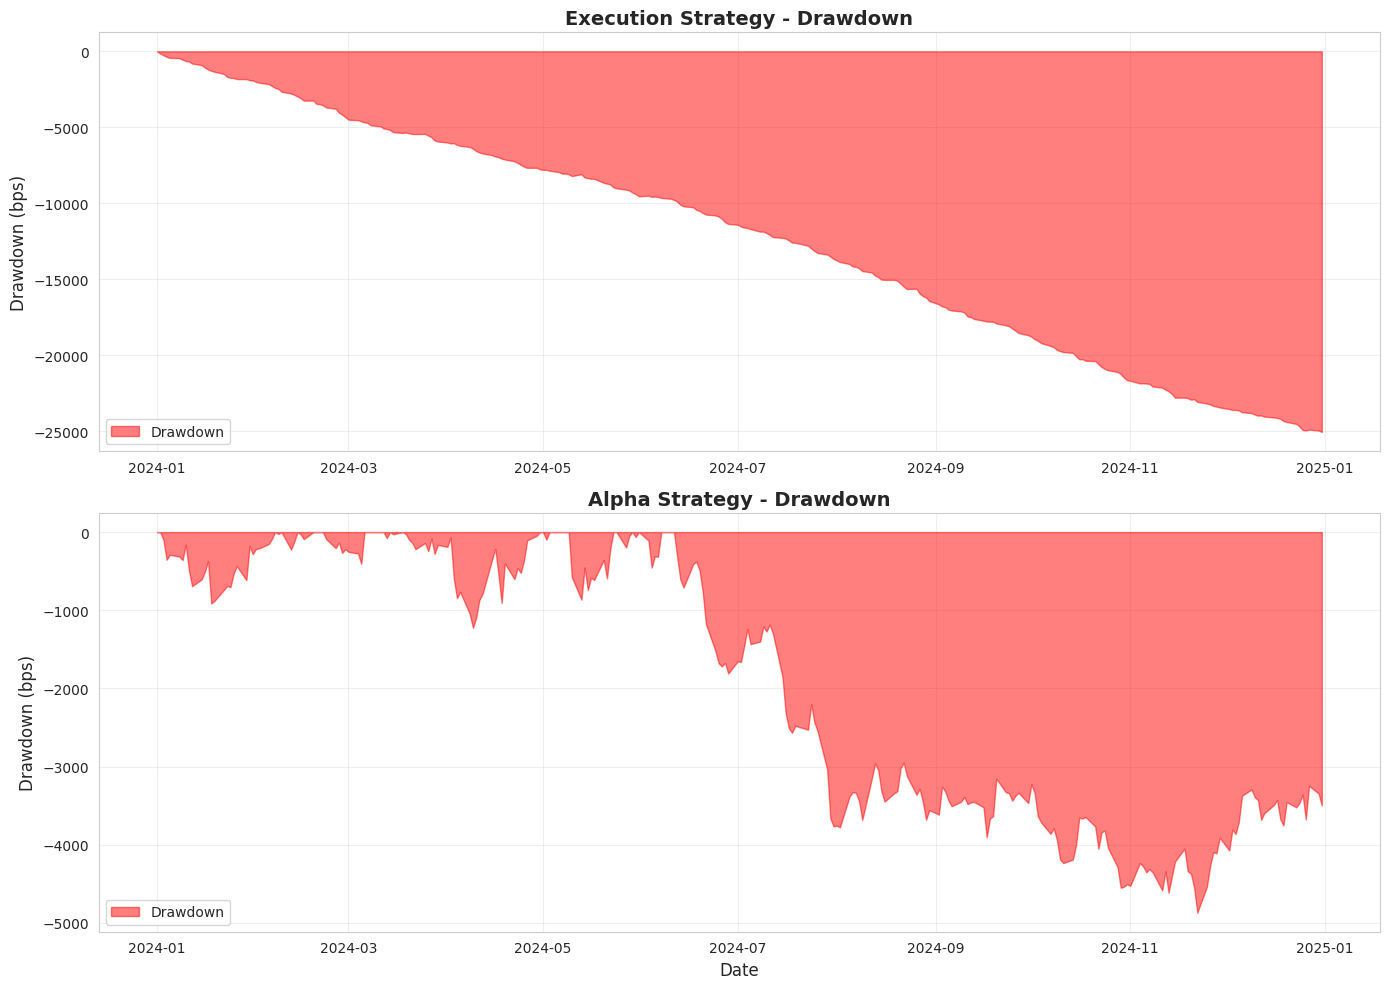

3. P&L Distribution...


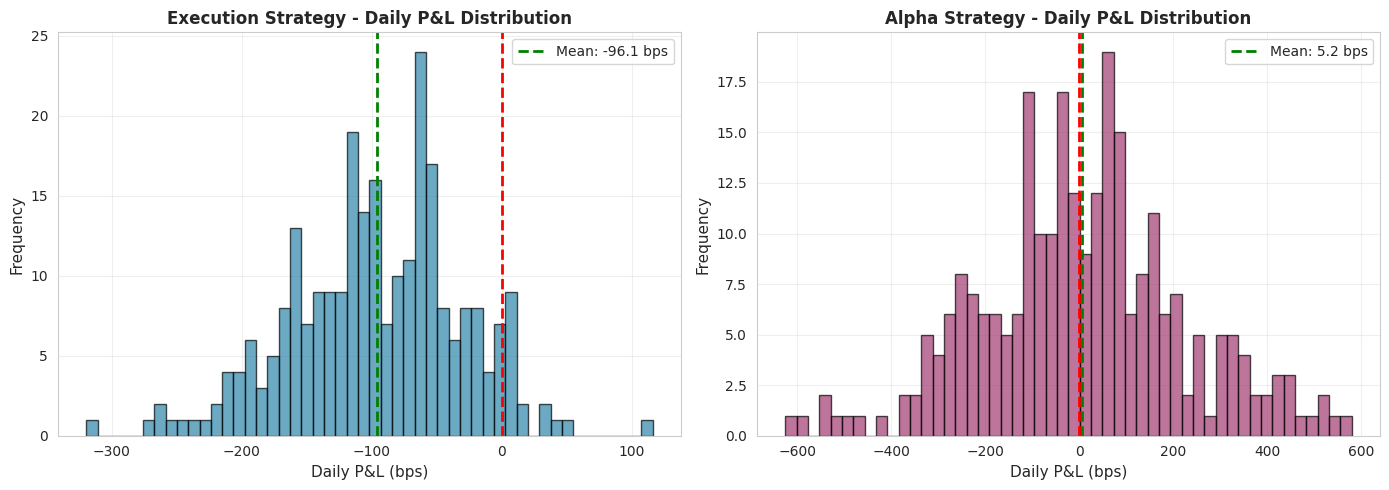

4. Sentiment Analysis...


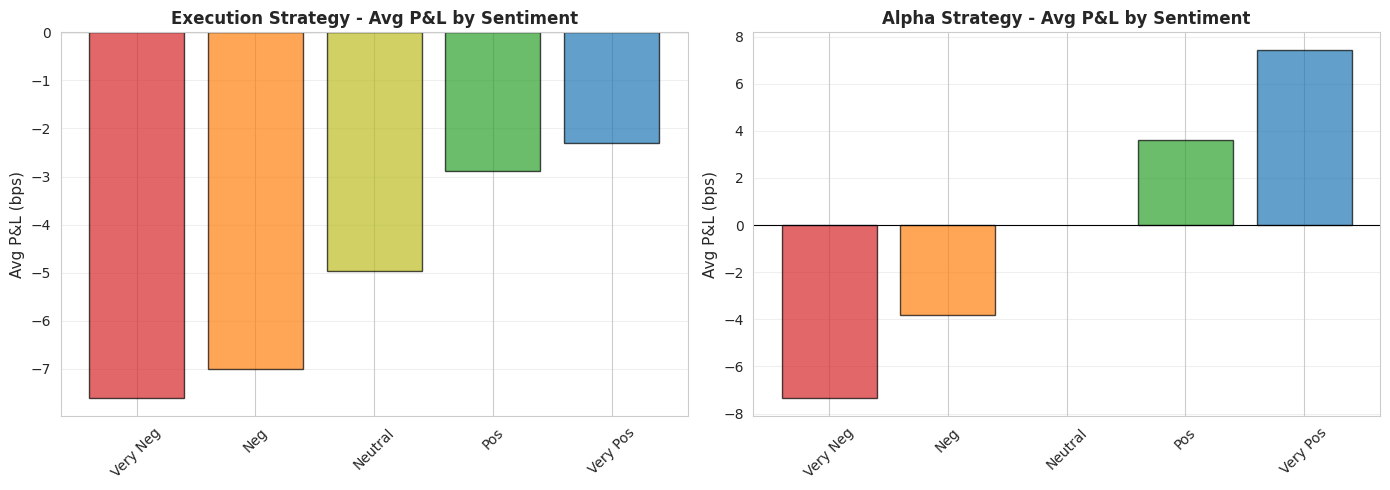

5. Sector Attribution...


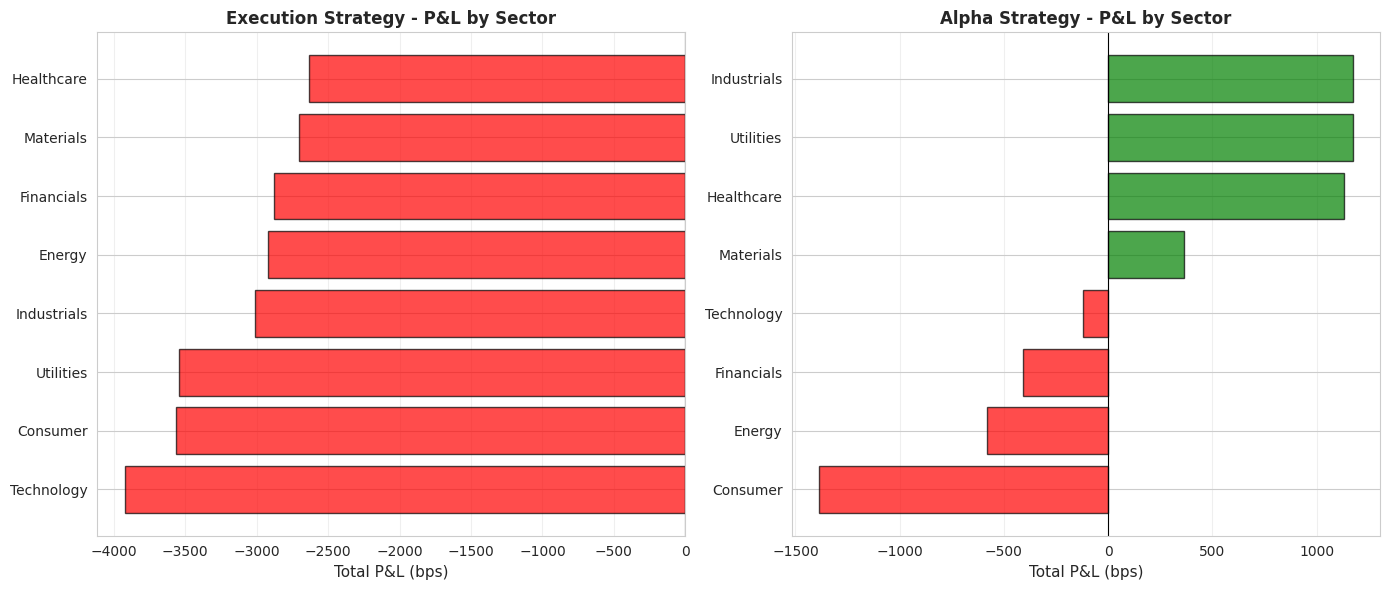

6. Rolling Sharpe Ratio...


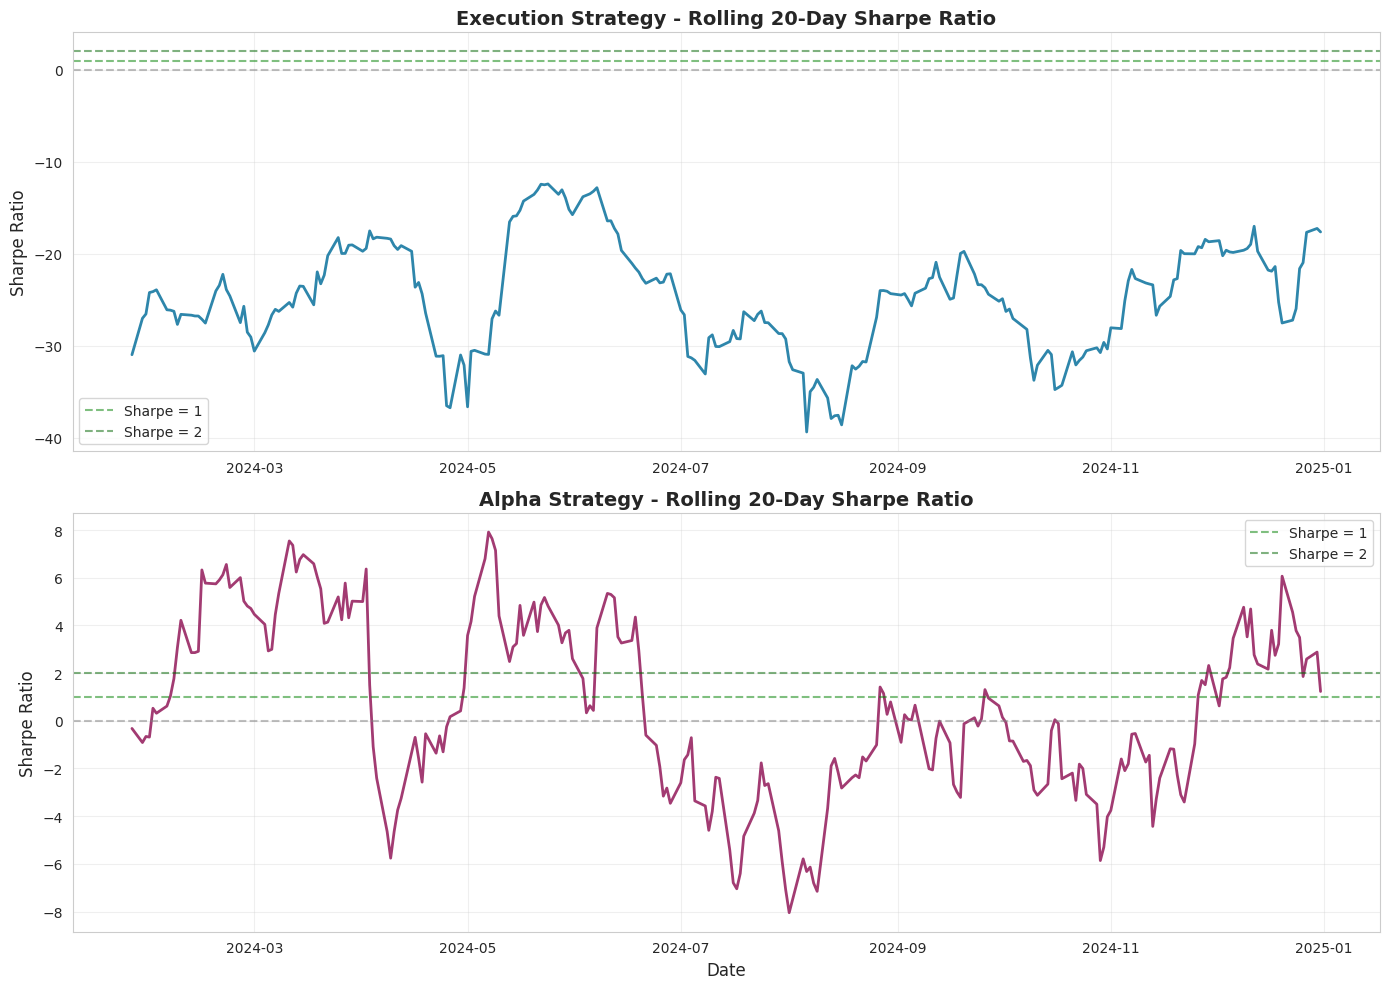


Analysis complete!


In [1]:
"""
Sentiment Backtesting Results - Analysis & Visualization
Connect to KDB or use mock data for visualization
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# ============================================================================
# SECTION 1: KDB CONNECTION (Optional - comment out if using mock data)
# ============================================================================

def connect_to_kdb(host='localhost', port=5000):
    """
    Connect to KDB and retrieve results
    Requires: pip install qpython
    """
    try:
        from qpython import qconnection

        q = qconnection.qconnection(host=host, port=port)
        q.open()

        # Retrieve execution results
        exec_results = q.sync('execResults')
        exec_stats = q.sync('execStats')

        # Retrieve alpha results
        alpha_results = q.sync('alphaResults')
        alpha_stats = q.sync('alphaStats')

        # Retrieve attribution
        attribution = q.sync('attribution')

        q.close()

        return {
            'exec_results': pd.DataFrame(exec_results),
            'exec_stats': exec_stats,
            'alpha_results': pd.DataFrame(alpha_results),
            'alpha_stats': alpha_stats,
            'attribution': attribution
        }
    except Exception as e:
        print(f"KDB connection failed: {e}")
        print("Using mock data instead...")
        return None

# ============================================================================
# SECTION 2: MOCK DATA GENERATION
# ============================================================================

def generate_mock_data(start_date='2024-01-01', end_date='2024-12-31', n_stocks=50):
    """Generate realistic mock backtesting results"""

    np.random.seed(42)

    # Date range
    dates = pd.date_range(start_date, end_date, freq='B')  # Business days

    # Stock universe (EuroStoxx 600 mock)
    stocks = [f'STOCK{i:03d}' for i in range(n_stocks)]
    sectors = ['Financials', 'Technology', 'Healthcare', 'Energy',
               'Industrials', 'Consumer', 'Materials', 'Utilities']

    # ========== EXECUTION TIMING RESULTS ==========
    exec_records = []
    for date in dates:
        # Random number of trades per day (10-30)
        n_trades = np.random.randint(10, 30)

        for _ in range(n_trades):
            stock = np.random.choice(stocks)

            # Sentiment score influences slippage
            sentiment = np.random.uniform(-0.8, 0.8)

            # Good execution timing reduces slippage
            # Positive sentiment + late execution = better
            # Negative sentiment + early execution = better
            base_slippage = np.random.normal(5, 15)  # bps
            timing_benefit = sentiment * np.random.uniform(2, 8)
            actual_slippage = base_slippage - timing_benefit

            exec_records.append({
                'timestamp': date + pd.Timedelta(hours=np.random.randint(8, 17)),
                'sym': stock,
                'avgScore': sentiment,
                'execPrice': 100 + np.random.normal(0, 5),
                'vwapPrice': 100 + np.random.normal(0, 5),
                'slippageBps': actual_slippage,
                'pnlBps': -actual_slippage  # Improvement over VWAP
            })

    exec_results = pd.DataFrame(exec_records)
    exec_results['date'] = exec_results['timestamp'].dt.date

    # ========== ALPHA STRATEGY RESULTS ==========
    alpha_records = []
    for date in dates:
        # Intraday rebalancing (every 30 min, ~15 times per day)
        for hour in range(8, 17):
            for minute in [0, 30]:
                rebal_time = pd.Timestamp(date) + pd.Timedelta(hours=hour, minutes=minute)

                # Random subset of stocks traded
                traded_stocks = np.random.choice(stocks, size=np.random.randint(5, 15), replace=False)

                for stock in traded_stocks:
                    sentiment = np.random.uniform(-1, 1)
                    signal = 1 if sentiment > 0.3 else (-1 if sentiment < -0.3 else 0)

                    if signal != 0:
                        # PnL based on sentiment quality and market conditions
                        base_return = np.random.normal(0, 20)  # bps
                        sentiment_alpha = signal * abs(sentiment) * np.random.uniform(5, 15)
                        pnl_bps = base_return + sentiment_alpha

                        alpha_records.append({
                            'timestamp': rebal_time,
                            'sym': stock,
                            'sentiment': sentiment,
                            'zScore': sentiment * np.random.uniform(0.5, 2),
                            'signal': signal,
                            'targetNotional': np.random.uniform(50000, 200000),
                            'pnlBps': pnl_bps
                        })

    alpha_results = pd.DataFrame(alpha_records)
    alpha_results['date'] = alpha_results['timestamp'].dt.date

    # ========== STATISTICS ==========
    exec_daily = exec_results.groupby('date')['pnlBps'].sum()
    alpha_daily = alpha_results.groupby('date')['pnlBps'].sum()

    def calc_stats(daily_returns):
        return {
            'sharpe': daily_returns.mean() / daily_returns.std() * np.sqrt(252),
            'maxDD': (daily_returns.cumsum() - daily_returns.cumsum().expanding().max()).min(),
            'avgReturn': daily_returns.mean(),
            'totalPnL': daily_returns.sum(),
            'winRate': (daily_returns > 0).mean() * 100
        }

    exec_stats = calc_stats(exec_daily)
    alpha_stats = calc_stats(alpha_daily)

    # ========== ATTRIBUTION ==========
    # Assign sectors to stocks
    stock_sectors = {stock: np.random.choice(sectors) for stock in stocks}
    exec_results['sector'] = exec_results['sym'].map(stock_sectors)
    alpha_results['sector'] = alpha_results['sym'].map(stock_sectors)

    attribution = {
        'bySector_exec': exec_results.groupby('sector').agg({
            'pnlBps': ['sum', 'mean', 'count']
        }).round(2),
        'bySector_alpha': alpha_results.groupby('sector').agg({
            'pnlBps': ['sum', 'mean', 'count']
        }).round(2)
    }

    return {
        'exec_results': exec_results,
        'exec_stats': exec_stats,
        'alpha_results': alpha_results,
        'alpha_stats': alpha_stats,
        'attribution': attribution
    }

# ============================================================================
# SECTION 3: VISUALIZATION FUNCTIONS
# ============================================================================

def plot_cumulative_pnl(exec_results, alpha_results):
    """Plot cumulative P&L for both strategies"""

    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Execution Strategy
    exec_daily = exec_results.groupby('date')['pnlBps'].sum().reset_index()
    exec_daily['cumPnL'] = exec_daily['pnlBps'].cumsum()

    axes[0].plot(exec_daily['date'], exec_daily['cumPnL'], linewidth=2, color='#2E86AB')
    axes[0].fill_between(exec_daily['date'], exec_daily['cumPnL'], alpha=0.3, color='#2E86AB')
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_title('Execution Timing Strategy - Cumulative P&L (bps)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Cumulative P&L (bps)', fontsize=12)
    axes[0].grid(True, alpha=0.3)

    # Alpha Strategy
    alpha_daily = alpha_results.groupby('date')['pnlBps'].sum().reset_index()
    alpha_daily['cumPnL'] = alpha_daily['pnlBps'].cumsum()

    axes[1].plot(alpha_daily['date'], alpha_daily['cumPnL'], linewidth=2, color='#A23B72')
    axes[1].fill_between(alpha_daily['date'], alpha_daily['cumPnL'], alpha=0.3, color='#A23B72')
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[1].set_title('Long/Short Alpha Strategy - Cumulative P&L (bps)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Cumulative P&L (bps)', fontsize=12)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_drawdown(exec_results, alpha_results):
    """Plot drawdown analysis"""

    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Execution Strategy
    exec_daily = exec_results.groupby('date')['pnlBps'].sum().reset_index()
    exec_daily['cumPnL'] = exec_daily['pnlBps'].cumsum()
    exec_daily['runningMax'] = exec_daily['cumPnL'].expanding().max()
    exec_daily['drawdown'] = exec_daily['cumPnL'] - exec_daily['runningMax']

    axes[0].fill_between(exec_daily['date'], exec_daily['drawdown'], 0,
                         alpha=0.5, color='red', label='Drawdown')
    axes[0].set_title('Execution Strategy - Drawdown', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Drawdown (bps)', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Alpha Strategy
    alpha_daily = alpha_results.groupby('date')['pnlBps'].sum().reset_index()
    alpha_daily['cumPnL'] = alpha_daily['pnlBps'].cumsum()
    alpha_daily['runningMax'] = alpha_daily['cumPnL'].expanding().max()
    alpha_daily['drawdown'] = alpha_daily['cumPnL'] - alpha_daily['runningMax']

    axes[1].fill_between(alpha_daily['date'], alpha_daily['drawdown'], 0,
                         alpha=0.5, color='red', label='Drawdown')
    axes[1].set_title('Alpha Strategy - Drawdown', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Drawdown (bps)', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_distribution(exec_results, alpha_results):
    """Plot P&L distribution"""

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Execution Strategy
    exec_daily = exec_results.groupby('date')['pnlBps'].sum()
    axes[0].hist(exec_daily, bins=50, alpha=0.7, color='#2E86AB', edgecolor='black')
    axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0].axvline(x=exec_daily.mean(), color='green', linestyle='--', linewidth=2,
                    label=f'Mean: {exec_daily.mean():.1f} bps')
    axes[0].set_title('Execution Strategy - Daily P&L Distribution', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Daily P&L (bps)', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Alpha Strategy
    alpha_daily = alpha_results.groupby('date')['pnlBps'].sum()
    axes[1].hist(alpha_daily, bins=50, alpha=0.7, color='#A23B72', edgecolor='black')
    axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[1].axvline(x=alpha_daily.mean(), color='green', linestyle='--', linewidth=2,
                    label=f'Mean: {alpha_daily.mean():.1f} bps')
    axes[1].set_title('Alpha Strategy - Daily P&L Distribution', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Daily P&L (bps)', fontsize=11)
    axes[1].set_ylabel('Frequency', fontsize=11)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_sentiment_analysis(exec_results, alpha_results):
    """Analyze P&L by sentiment bucket"""

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Execution Strategy - Slippage by Sentiment
    exec_results['sentiment_bucket'] = pd.cut(exec_results['avgScore'],
                                               bins=[-1, -0.5, -0.2, 0.2, 0.5, 1],
                                               labels=['Very Neg', 'Neg', 'Neutral', 'Pos', 'Very Pos'])

    sentiment_perf_exec = exec_results.groupby('sentiment_bucket')['pnlBps'].agg(['mean', 'std', 'count'])

    axes[0].bar(range(len(sentiment_perf_exec)), sentiment_perf_exec['mean'],
                color=['#d62728', '#ff7f0e', '#bcbd22', '#2ca02c', '#1f77b4'],
                alpha=0.7, edgecolor='black')
    axes[0].set_xticks(range(len(sentiment_perf_exec)))
    axes[0].set_xticklabels(sentiment_perf_exec.index, rotation=45)
    axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[0].set_title('Execution Strategy - Avg P&L by Sentiment', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Avg P&L (bps)', fontsize=11)
    axes[0].grid(True, alpha=0.3, axis='y')

    # Alpha Strategy
    alpha_results['sentiment_bucket'] = pd.cut(alpha_results['sentiment'],
                                                bins=[-1, -0.5, -0.2, 0.2, 0.5, 1],
                                                labels=['Very Neg', 'Neg', 'Neutral', 'Pos', 'Very Pos'])

    sentiment_perf_alpha = alpha_results.groupby('sentiment_bucket')['pnlBps'].agg(['mean', 'std', 'count'])

    axes[1].bar(range(len(sentiment_perf_alpha)), sentiment_perf_alpha['mean'],
                color=['#d62728', '#ff7f0e', '#bcbd22', '#2ca02c', '#1f77b4'],
                alpha=0.7, edgecolor='black')
    axes[1].set_xticks(range(len(sentiment_perf_alpha)))
    axes[1].set_xticklabels(sentiment_perf_alpha.index, rotation=45)
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[1].set_title('Alpha Strategy - Avg P&L by Sentiment', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Avg P&L (bps)', fontsize=11)
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

def plot_sector_attribution(attribution):
    """Plot sector attribution"""

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Execution Strategy
    sector_exec = attribution['bySector_exec']['pnlBps']['sum'].sort_values()
    colors_exec = ['red' if x < 0 else 'green' for x in sector_exec.values]

    axes[0].barh(range(len(sector_exec)), sector_exec.values, color=colors_exec, alpha=0.7, edgecolor='black')
    axes[0].set_yticks(range(len(sector_exec)))
    axes[0].set_yticklabels(sector_exec.index)
    axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[0].set_title('Execution Strategy - P&L by Sector', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Total P&L (bps)', fontsize=11)
    axes[0].grid(True, alpha=0.3, axis='x')

    # Alpha Strategy
    sector_alpha = attribution['bySector_alpha']['pnlBps']['sum'].sort_values()
    colors_alpha = ['red' if x < 0 else 'green' for x in sector_alpha.values]

    axes[1].barh(range(len(sector_alpha)), sector_alpha.values, color=colors_alpha, alpha=0.7, edgecolor='black')
    axes[1].set_yticks(range(len(sector_alpha)))
    axes[1].set_yticklabels(sector_alpha.index)
    axes[1].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[1].set_title('Alpha Strategy - P&L by Sector', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Total P&L (bps)', fontsize=11)
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

def plot_rolling_sharpe(exec_results, alpha_results, window=20):
    """Plot rolling Sharpe ratio"""

    fig, axes = plt.subplots(2, 1, figsize=(14, 10))

    # Execution Strategy
    exec_daily = exec_results.groupby('date')['pnlBps'].sum().reset_index()
    exec_daily['rolling_sharpe'] = (
        exec_daily['pnlBps'].rolling(window).mean() /
        exec_daily['pnlBps'].rolling(window).std() * np.sqrt(252)
    )

    axes[0].plot(exec_daily['date'], exec_daily['rolling_sharpe'], linewidth=2, color='#2E86AB')
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1')
    axes[0].axhline(y=2, color='darkgreen', linestyle='--', alpha=0.5, label='Sharpe = 2')
    axes[0].set_title(f'Execution Strategy - Rolling {window}-Day Sharpe Ratio', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Sharpe Ratio', fontsize=12)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Alpha Strategy
    alpha_daily = alpha_results.groupby('date')['pnlBps'].sum().reset_index()
    alpha_daily['rolling_sharpe'] = (
        alpha_daily['pnlBps'].rolling(window).mean() /
        alpha_daily['pnlBps'].rolling(window).std() * np.sqrt(252)
    )

    axes[1].plot(alpha_daily['date'], alpha_daily['rolling_sharpe'], linewidth=2, color='#A23B72')
    axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[1].axhline(y=1, color='green', linestyle='--', alpha=0.5, label='Sharpe = 1')
    axes[1].axhline(y=2, color='darkgreen', linestyle='--', alpha=0.5, label='Sharpe = 2')
    axes[1].set_title(f'Alpha Strategy - Rolling {window}-Day Sharpe Ratio', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Date', fontsize=12)
    axes[1].set_ylabel('Sharpe Ratio', fontsize=12)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def print_summary_stats(exec_stats, alpha_stats):
    """Print summary statistics table"""

    print("="*80)
    print("BACKTEST SUMMARY STATISTICS")
    print("="*80)
    print()

    stats_df = pd.DataFrame({
        'Execution Timing': [
            f"{exec_stats['sharpe']:.2f}",
            f"{exec_stats['totalPnL']:.0f}",
            f"{exec_stats['avgReturn']:.2f}",
            f"{exec_stats['maxDD']:.0f}",
            f"{exec_stats['winRate']:.1f}%"
        ],
        'Long/Short Alpha': [
            f"{alpha_stats['sharpe']:.2f}",
            f"{alpha_stats['totalPnL']:.0f}",
            f"{alpha_stats['avgReturn']:.2f}",
            f"{alpha_stats['maxDD']:.0f}",
            f"{alpha_stats['winRate']:.1f}%"
        ]
    }, index=['Sharpe Ratio', 'Total P&L (bps)', 'Avg Daily P&L (bps)',
              'Max Drawdown (bps)', 'Win Rate'])

    print(stats_df.to_string())
    print()
    print("="*80)

# ============================================================================
# SECTION 4: MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":

    print("Sentiment Backtesting Results Analysis")
    print("="*80)
    print()

    # Try to connect to KDB, otherwise use mock data
    # data = connect_to_kdb()  # Uncomment to use real KDB data
    data = None

    if data is None:
        print("Generating mock data...")
        data = generate_mock_data(start_date='2024-01-01', end_date='2024-12-31', n_stocks=50)
        print("Mock data generated successfully!")
        print()

    # Extract data
    exec_results = data['exec_results']
    exec_stats = data['exec_stats']
    alpha_results = data['alpha_results']
    alpha_stats = data['alpha_stats']
    attribution = data['attribution']

    # Print summary statistics
    print_summary_stats(exec_stats, alpha_stats)

    # Generate all visualizations
    print("Generating visualizations...")
    print()

    print("1. Cumulative P&L...")
    plot_cumulative_pnl(exec_results, alpha_results)

    print("2. Drawdown Analysis...")
    plot_drawdown(exec_results, alpha_results)

    print("3. P&L Distribution...")
    plot_distribution(exec_results, alpha_results)

    print("4. Sentiment Analysis...")
    plot_sentiment_analysis(exec_results, alpha_results)

    print("5. Sector Attribution...")
    plot_sector_attribution(attribution)

    print("6. Rolling Sharpe Ratio...")
    plot_rolling_sharpe(exec_results, alpha_results, window=20)

    print()
    print("="*80)
    print("Analysis complete!")
    print("="*80)